In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as lng
import time
import pandas as pd
from scipy.sparse.linalg import spsolve
from scipy import sparse
import scipy.linalg as lng_scp
plt.rcParams["figure.figsize"]=(16,9)

In [2]:
#Possibilities are iteration_policy ,penalized_iteration_policy, newton
Scheme='newton'

In [3]:
c=1/8
sigma=0.2
mu=0.06
r=0.02
x_max=2
x_val=1

In [4]:
def l(x,n):
    out=np.zeros_like(x)
    for i in range(n):
        if (x[i]>=0.5 and x[i]<=1.5):
            out[i]=0.5-np.abs(x[i]-1)
    return out
def vR(t):
    return 0

def interpolated_value(x_bar,h,U,x):
    i=int((x_bar)/h)-1
    return float((x[i+1]-x_bar)*U[i]/h+(x_bar-x[i])*U[i+1]/h)

def make_output_table (table,s_val):
    table["error"]=np.abs(table['U(%.2f)' %s_val].diff())
    for i in range(1, len(table)):
        table.loc[i,"error order"]=np.log(table.loc[i-1,"error"]/table.loc[i,"error"])/np.log((table.loc[i,"N"])/(table.loc[i-1,"N"]))
    return table

In [19]:
#of course in this case newton method is the same as policy iteration
def newton(A,l,M,b,k_max,tol,scale):
    k=0
    x=lng.solve(A,l)
    n=len(b)
    relative_error=1
    x_old=x
    while (k<k_max and relative_error>tol):
        F_derivative=np.zeros_like(A)
        vec_left=A@(x)
        vec_right=M@(x)
        for i in range(n):
            #return (vec_left,vec_right,b,g)
            if ((vec_left[i]-l[i])<=(vec_right[i]-b[i])):
                for j in range(n):
                    F_derivative[i,j]=A[i,j]
            if ((vec_left[i]-l[i])>(vec_right[i]-b[i])):
                for j in range(n):
                    F_derivative[i,j]=M[i,j]
        F=np.minimum(vec_left-l,vec_right-b)
        x=x-lng.solve(F_derivative,F)
        relative_error=lng.norm(x_old-x,np.inf)/np.minimum(lng.norm(x,np.inf),scale)
        x_old=x
        k=k+1
    error_min=np.minimum(A@(x)-l,M@(x)-b)
    print(lng.norm(error_min,np.inf))
    return x,k-1

def policy_iteration(A,l,M,b,k_max,tol,scale):
    u_old=np.zeros_like(b)
    u_iter=lng.solve(A,l)
    w=np.zeros_like(b)
    relative_error=1
    #if we start with ones vector we will have singular matrix problem 
    #w=np.ones_like(b)
    k=0
    A_iter=np.zeros_like(A)
    b_iter=np.zeros_like(b)
    n=len(b)
    while (k<k_max and relative_error>tol):
        i=0
        while (i<n):
            A_iter[i,:]=(1-w[i])*A[i,:]+w[i]*M[i,:]
            b_iter[i]=(1-w[i])*l[i]+w[i]*b[i]
            i=i+1
        u_iter=lng.solve(A_iter,b_iter)
        
        w_0=A@(u_iter)-l
        w_1=M@(u_iter)-b
        i=0
        while (i<n):
            if w_0[i]<w_1[i]:
                w[i]=0
            else:
                w[i]=1
            i=i+1
        relative_error=lng.norm(u_old-u_iter,np.inf)/np.minimum(lng.norm(u_iter,np.inf),scale)
        u_old=u_iter
        k=k+1
    error_min=np.minimum(A@(u_iter)-l,M@(u_iter)-b)
    print(lng.norm(error_min,np.inf))
    return u_iter,k


#scheme when we try to do PSOR at both u_i at the same time (the algo fails)
def Psor(A,b,Q,g,k_max,x0):
    k=0
    x=x0
    xold=x0
    U_matrix=np.triu(A,k=1)
    L=np.tril(A,k=0)
    I=len(g)
    n=int(I/2)
    while (k<k_max):
        c=b-U_matrix@(xold)
        xold=x
        for i in range(n):
            sum_mult=0
            sum_mult_2=0
            for j in range(n):
                if (j!=i):
                    sum_mult=sum_mult+L[i,j]*x[j]
            for j in range(n):
                if (j!=i+n):
                    sum_mult_2=sum_mult_2+L[i+n,j]*x[j]
            x[i]=(c[i]-sum_mult)/L[i,i]
            x[i+n]=(c[i+n]-sum_mult_2)/L[i+n,i+n]
            x_i=np.maximum(x[i],-g[i]+x[i+n])
            x_i_plus_n=np.maximum(x[i+n],-g[i+n]+x[i])
            x[i]=x_i
            x[i+n]=x_i_plus_n
        k=k+1
    error_min=np.minimum(A@(x)-b,Q@(x)-g)
    print(lng.norm(error_min,np.inf))   
    return x

#scheme when we try to do PSOR at only one of u_i at time (the algo fails)
def Psor2(A,b,Q,g,k_max,x0):
    k=0
    x=x0
    xold=x0
    U_matrix=np.triu(A,k=1)
    L=np.tril(A,k=0)
    I=len(g)
    n=int(I/2)
    while (k<k_max):
        c=b-U_matrix@(xold)
        xold=x
        for i in range(2*n):
            sum_mult=0
            for j in range(2*n):
                if (j!=i):
                    sum_mult=sum_mult+L[i,j]*x[j]
            x[i]=(c[i]-sum_mult)/L[i,i]
            if (i<n):
                x[i]=np.maximum(x[i],-g[i]+x[i+n])
            else:
                x[i]=np.maximum(x[i],-g[i]+x[i-n])
        k=k+1
    error_min=np.minimum(A@(x)-b,Q@(x)-g)
    print(lng.norm(error_min,np.inf))   
    return x

In [6]:
table_iteration=[]
table_penalized_1000=[]
table_penalized_10000=[]
tabke_penalized_100000=[]

table_1=[]

1.7479351299698465e-12


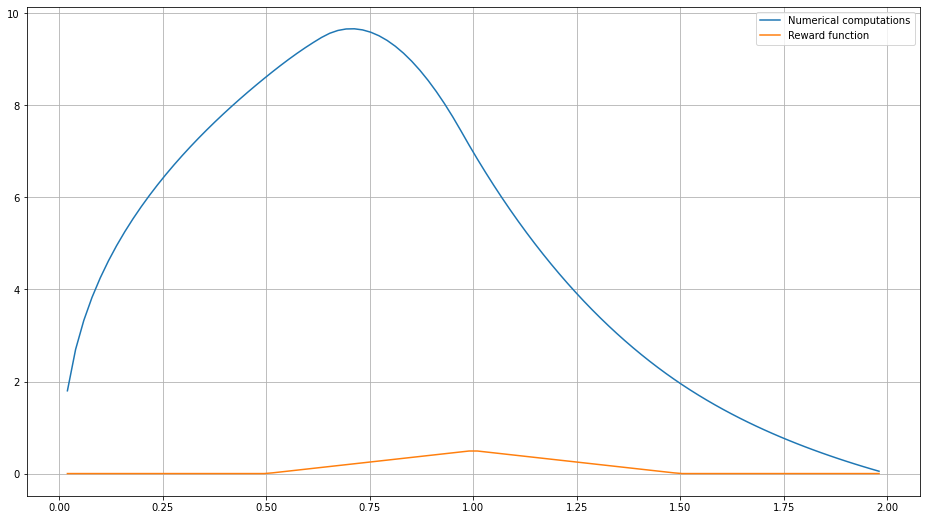

2.7569058147491887e-12


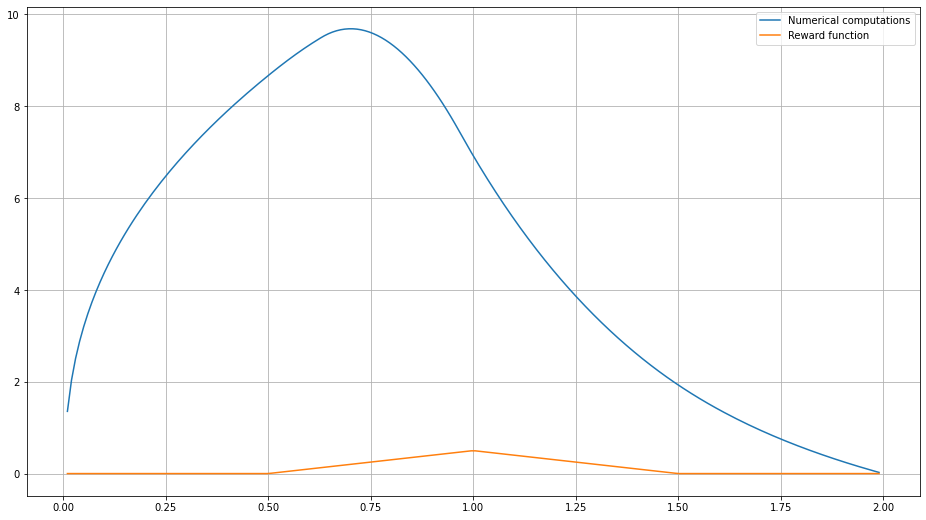

5.172751116333529e-12


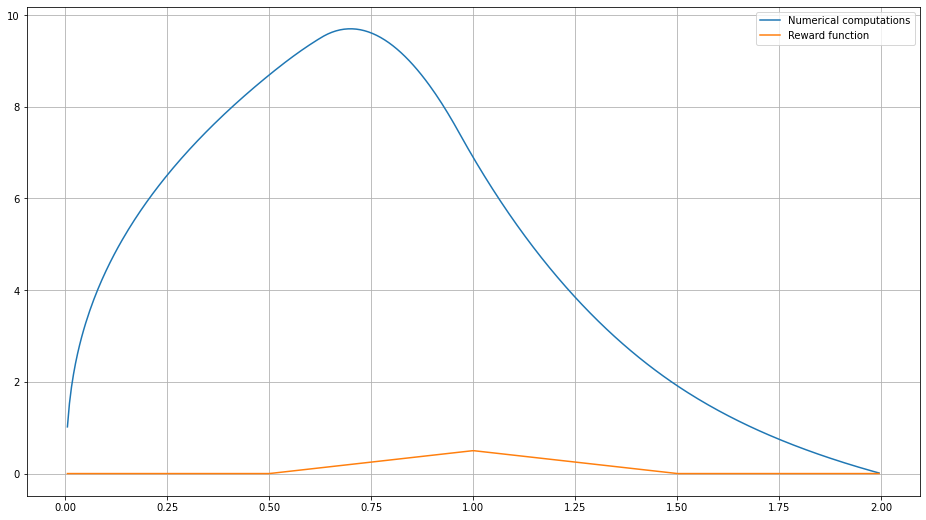

1.6277756920146658e-11


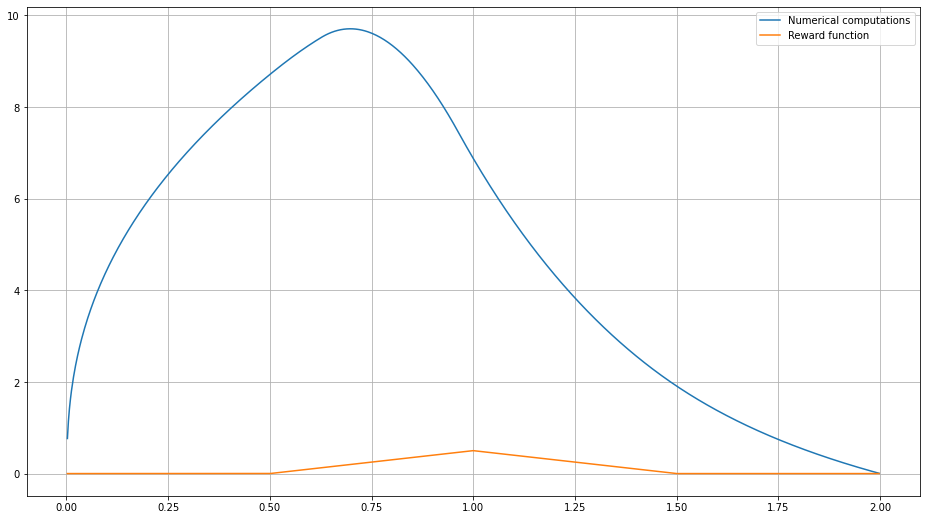

Wall time: 31.7 s


In [20]:
%%time
table_1=[]
#one can change the maximum number of iterations
k_max=200
tol=0.0001
scale=1
#Scheme='penalized_iteration_policy'
#iteration_policy, penalized_iteration_policy, newton

if (Scheme=='iteration_policy'):
    iteration_range=[100,200,400,800,1600]
if (Scheme=='penalized_iteration_policy'):
    iteration_range=[100,200,400,800,1600,3200]
if (Scheme=='newton'):
    iteration_range=[100,200,400,800]
if (Scheme=='PSOR'):
    iteration_range=[100,200,400,800]

#iteration_range=[1600]
for n in iteration_range:
    h=(x_max)/(n+1)
    x=h*np.arange(1,n+1)
    alpha=(sigma**2/2)*(x**2/h**2)
    beta=x/h
    r_vec=np.ones(n)*r
    start_time=time.time()
    A_0=np.diag(r_vec+r*beta)+np.diag(-r*beta[0:-1],1)
    A_1=np.diag(2*alpha+r_vec+mu*beta)+np.diag(-alpha[1:],-1)+np.diag(-alpha[0:-1]-mu*beta[0:-1],1)

    zeros_matrix=np.zeros_like(A_0)
    A=np.bmat([[A_0,zeros_matrix],[zeros_matrix,A_1]])
    A=np.squeeze(np.asarray(A))
    identity=np.eye(n)
    Q=np.bmat([[identity,-identity],[-identity,identity]])
    Q=np.squeeze(np.asarray(Q))
    g=c*np.ones(2*n)
    b=l(x,n)
    b=np.concatenate((b,b))
    if (Scheme=='iteration_policy'):
        rho=0
        U,final_k=policy_iteration(A,b,Q,-g,k_max,tol,scale)
    #below penalized 
    if (Scheme=='penalized_iteration_policy'):
        rho=10000
        U,final_k=policy_iteration(A,b,rho*Q+A,-rho*g+b,k_max,tol,scale)
    if (Scheme=='newton'):
        rho=1000
        x_0=np.ones(2*n)
        U,final_k=newton(A,b,rho*Q+A,-rho*g+b,k_max,tol,scale)
    if (Scheme=='PSOR'):
        U=Psor(A,b,Q,-g,k_max,x0)
    
    plt.plot(x,U[n:2*n], label="Numerical computations")
    plt.legend("Outcome of the computations")
    plt.plot(x,b[n:2*n],label="Reward function")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()
    
    table_1.append(
        {'N': n,
        'number of iterations': final_k,
        'computation time': time.time() - start_time,
        'U(%.2f)' %x_val:  interpolated_value(x_val,h,U,x),
        'rho': rho})
    
    
table_1=pd.DataFrame(table_1)

In [21]:
make_output_table(table_1,x_val)

,N,number of iterations,computation time,U(1.00),rho,error,error order
0,100,8,0.445833,7.075418,1000,NaN,NaN
1,200,13,1.382580,7.006048,1000,0.069370,NaN
2,400,17,5.197448,6.969576,1000,0.036471,0.927558
3,800,18,24.670340,6.950451,1000,0.019125,0.931264


In [ ]:
table_penalized_100000=make_output_table(table_1,x_val)

In [ ]:
plt.plot(table_iteration['N'],table_iteration['number of iterations'], marker='D', label="policy iteration")
plt.plot(table_penalized_1000['N'],table_penalized_1000['number of iterations'], marker='D', label="penalized policy iteration with ρ=1000")
plt.plot(table_penalized_10000['N'],table_penalized_10000['number of iterations'], marker='D', label="penalized policy iteration with ρ=10000")
plt.plot(table_penalized_100000['N'],table_penalized_100000['number of iterations'], marker='D', label="penalized policy iteration with ρ=100000")
plt.legend(loc="upper right")
plt.xlabel("N")
plt.ylabel("number of iterations")
plt.grid()
plt.show()

In [ ]:
plt.plot(table_iteration['N'],table_iteration['computation time'], marker='D', label="policy iteration")
plt.plot(table_penalized_1000['N'],table_penalized_1000['computation time'], marker='D', label="penalized policy iteration with ρ=1000")
plt.plot(table_penalized_10000['N'],table_penalized_10000['computation time'], marker='D', label="penalized policy iteration with ρ=10000")
plt.plot(table_penalized_100000['N'],table_penalized_100000['computation time'], marker='D', label="penalized policy iteration with ρ=100000")
plt.legend(loc="upper right")
plt.xlabel("N")
plt.ylabel("time of computations")
plt.grid()
plt.show()

In [ ]:
U_iteration=U

In [ ]:
U_1000=U

In [ ]:
U_10000=U

In [ ]:
U_100000=U

In [ ]:
plt.plot(x,U_iteration[n:2*n]-U_1000[n:2*n], label="policy iteration-penalized (ρ=1000)")
plt.plot(x,U_iteration[n:2*n]-U_10000[n:2*n], label="policy iteration-penalized (ρ=10000)")
plt.plot(x,U_iteration[n:2*n]-U_100000[n:2*n], linestyle='--', label="policy iteration-penalized (ρ=100000)")
plt.xlabel("t")
#plt.xscale("log")
#plt.yscale("log")
plt.ylabel("policy iteration-penalized scheme")
plt.legend(loc="upper right")